<a href="https://colab.research.google.com/github/Moh-Bxd/Brain_tumor_detection/blob/main/brain_Tumor_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [49]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from os import listdir
from google.colab import drive


# Reading the Images

In [2]:
drive.mount('/content/gdrive')
directory = '/content/gdrive/My Drive/data Training Camp/yes'
directory2 = '/content/gdrive/My Drive/data Training Camp/no'

tumor = []
healthy = []
if os.path.exists(directory):
    for filename in os.listdir(directory):
        full_path = os.path.join(directory, filename)
        img = cv2.imread(full_path)

        if img is not None:
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            tumor.append(img)
        else:
            print(f"Unable to read image: {full_path}")
else:
    print(f"Directory not found: {directory}")

if os.path.exists(directory2):
    for filename in os.listdir(directory2):
        full_path = os.path.join(directory2, filename)
        img = cv2.imread(full_path)

        if img is not None:
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            healthy.append(img)
        else:
            print(f"Unable to read image: {full_path}")
else:
    print(f"Directory not found: {directory2}")


Mounted at /content/gdrive


In [3]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [87]:
healthy.shape


(438, 128, 128, 3)

In [88]:
tumor.shape

(913, 128, 128, 3)

# Visualizing Brain MRI Images

In [5]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])


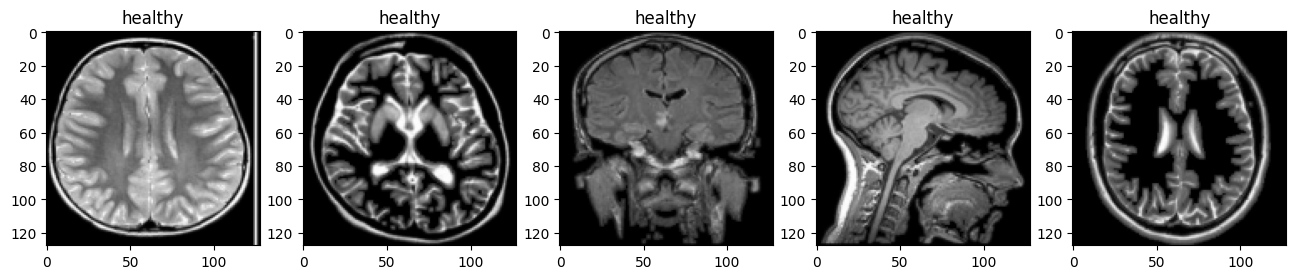

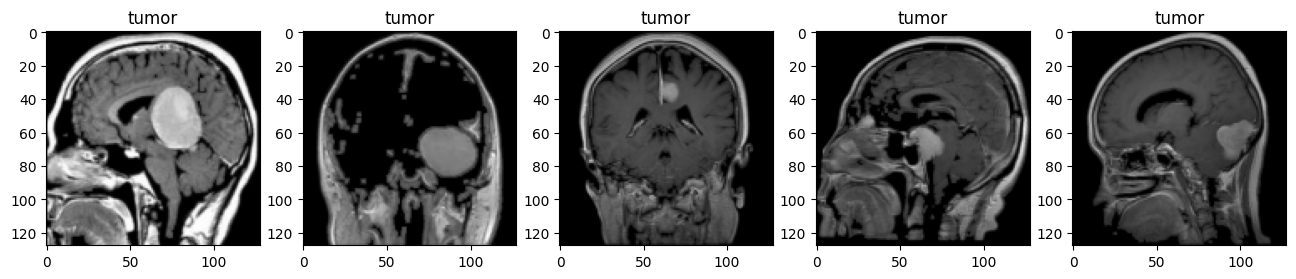

In [ ]:
plot_random(healthy, tumor, num=5)


# What is Pytorch's Abstract Dataset Class


In [4]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Creating Custum DataSet

In [23]:
from torch.utils.data import Dataset
from google.colab import drive
import os
import cv2
import numpy as np

class MRI(Dataset):
    def __init__(self):
        drive.mount('/content/gdrive')
        directory = '/content/gdrive/My Drive/data Training Camp/yes'
        directory2 = '/content/gdrive/My Drive/data Training Camp/no'

        tumor = []
        healthy = []

        if os.path.exists(directory):
            for filename in os.listdir(directory):
                full_path = os.path.join(directory, filename)
                img = cv2.imread(full_path)

                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    b, g, r = cv2.split(img)
                    img = cv2.merge([r, g, b])
                    tumor.append(img)
                else:
                    print(f"Unable to read image: {full_path}")
        else:
            print(f"Directory not found: {directory}")

        if os.path.exists(directory2):
            for filename in os.listdir(directory2):
                full_path = os.path.join(directory2, filename)
                img = cv2.imread(full_path)

                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    b, g, r = cv2.split(img)
                    img = cv2.merge([r, g, b])
                    healthy.append(img)
                else:
                    print(f"Unable to read image: {full_path}")
        else:
            print(f"Directory not found: {directory2}")

        # our images
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        assert np.array_equal(np.unique(tumor_label), [1])
        assert np.array_equal(np.unique(healthy_label), [0])

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.images = self.images.reshape(-1, 3, 128, 128)
        self.labels = np.concatenate((tumor_label, healthy_label))


    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': int(self.labels[index])}
        return sample

    def normalize(self):
        self.images = self.images / 255.0


In [28]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.__len__()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


1351

In [ ]:
# # One way of iterating
# names={0:'Heathy', 1:'Tumor'}
# dataloader = DataLoader(mri_dataset, shuffle=True)
# for i, sample in enumerate(dataloader):
#     img = sample['image'].squeeze()
#     img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
#     plt.title(names[sample['label'].item()])
#     plt.imshow(img)
#     plt.show()
#     if i == 5:
#         break


# Split data


In [25]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset


X_train, X_temp, y_train, y_temp = train_test_split(mri_dataset.images, mri_dataset.labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val).long())
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())

print(train_dataset)


In [124]:
X_train.shape

(1080, 128, 128, 3)

# Create a model


In [44]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3),
            nn.Tanh(),
            nn.BatchNorm2d(3),
            nn.AvgPool2d(kernel_size=5, stride=1),

            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3),  # New Convolutional Layer 01
            nn.Tanh(),
            nn.BatchNorm2d(3),
            nn.AvgPool2d(kernel_size=5, stride=1),

            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(kernel_size=5, stride=1)
        )

        # Adjust the in_features calculation based on the convolutional layers

        self.fc_model = nn.Sequential(
            nn.Linear(in_features= 16*108*108, out_features=256),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=128),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=64),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        # Print the shape of x after convolutional layers

        x = x.reshape(x.size(0), -1)

        x = self.fc_model(x)

        # Print the shape of x after linear layers

        return x


# Training

Epoch 1, Loss: 0.6252046052147361, Train Accuracy: 62.592592592592595, Test Accuracy: 59.55882352941177
Epoch 2, Loss: 0.6334224167992087, Train Accuracy: 66.94444444444444, Test Accuracy: 67.6470588235294
Epoch 3, Loss: 0.6117028944632587, Train Accuracy: 67.5, Test Accuracy: 66.17647058823529
Epoch 4, Loss: 0.6001164983300602, Train Accuracy: 68.24074074074075, Test Accuracy: 65.44117647058823
Epoch 5, Loss: 0.5837489892454708, Train Accuracy: 68.24074074074075, Test Accuracy: 67.6470588235294
Epoch 6, Loss: 0.5690953345859752, Train Accuracy: 70.74074074074075, Test Accuracy: 69.11764705882354
Epoch 7, Loss: 0.5453466860687032, Train Accuracy: 73.88888888888889, Test Accuracy: 73.52941176470588
Epoch 8, Loss: 0.5226719169055715, Train Accuracy: 75.46296296296296, Test Accuracy: 73.52941176470588
Epoch 9, Loss: 0.5019664256011739, Train Accuracy: 76.20370370370371, Test Accuracy: 75.0
Epoch 10, Loss: 0.485185419811922, Train Accuracy: 76.48148148148148, Test Accuracy: 66.176470588235

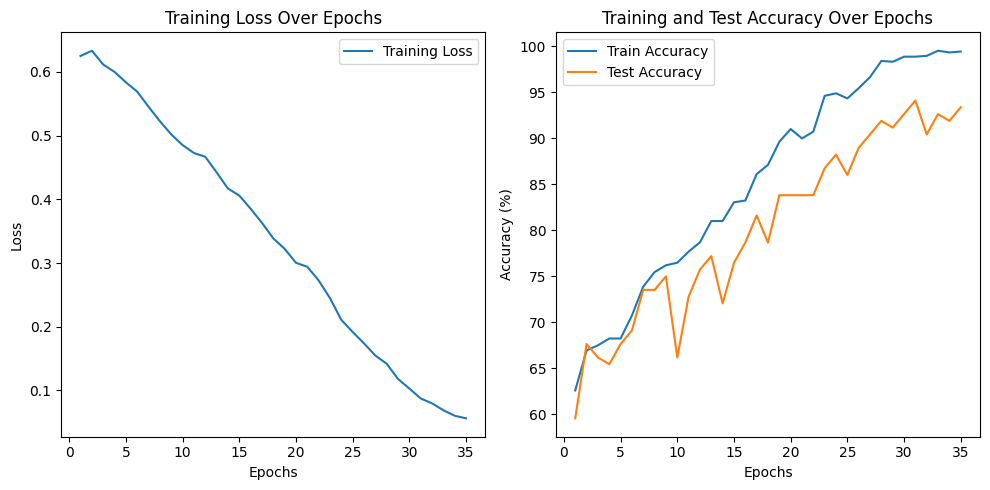

In [50]:
# The dataLoaders
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# trainloader.dataset.data.dtype
# initialising the cnn

brain = CNN()

# loss function and optimizer

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(brain.parameters(), lr=0.001, momentum=0.9)

# Define a function for calculating accuracy
def calculate_accuracy(dataloader, model, threshold=0.5):
    total = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            predicted = (sigmoid_outputs > threshold).float()
            predicted = predicted.view(-1)
            labels = labels.view(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total
######################## Training

train_accuracies = []
test_accuracies = []
train_losses = []
epochs = 35
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        labels = labels.view(-1, 1)
        optimizer.zero_grad()  # Zero the gradients before backward pass
        outputs = brain(inputs)
        outputs = outputs.view(-1, 1)  # Assign the modified shape back to outputs
        loss = criterion(outputs, labels.float())  # Ensure labels are of type float
        loss.backward()
        optimizer.step()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        running_loss += loss.detach().item()

    train_accuracy = calculate_accuracy(trainloader, brain)
    test_accuracy = calculate_accuracy(testloader, brain)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(running_loss / len(trainloader))
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, '
          f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

epochs_list = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies, label='Train Accuracy')
plt.plot(epochs_list, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()



In [51]:
torch.save(brain.state_dict(),"/content/gdrive/My Drive/data Training Camp/brain2.pt")
